# Chapter 1

## Fig 1.07 Collins toggle switch

For Figures 1.7, 7.13, 7.14, 7.15

In [1]:
using DifferentialEquations
using ModelingToolkit
using Plots
Plots.gr(lw=2, fmt=:png)

Plots.GRBackend()

In [2]:
# Convenience functions
hill(x, k) = x / (x + k)
hill(x, k, n) = hill(x^n, k^n)

hill (generic function with 2 methods)

In [3]:
# Model
@parameters a1 a2 β γ
@variables t s1(t) s2(t) i1(t) i2(t)

D = Differential(t)

# Time-dependent inhibitor levels
i1_fun(t) = ifelse(30<= t <= 40, 10, 0)
i2_fun(t) = ifelse(10<= t <= 20, 10, 0)

@register i1_fun(t)
@register i2_fun(t)

In [4]:
@named collinsSys = ODESystem([ i1 ~ i1_fun(t),
                                i2 ~ i2_fun(t),
                                D(s1) ~ a1 * hill(1 + i2, s2, β) - s1,
                                D(s2) ~ a2 * hill(1 + i1, s1, γ) - s2])

Model collinsSys with 4 equations
States (4):
  s1(t)
  s2(t)
  i1(t)
  i2(t)
Parameters (4):
  a1
  β
  a2
  γ
Incidence matrix:sparse([1, 2, 1, 2, 1, 2, 1, 4, 2, 3], [1, 2, 3, 3, 4, 4, 5, 5, 6, 6], Num[×, ×, ×, ×, ×, ×, ×, ×, ×, ×], 4, 6)

In [5]:
collinsSys = structural_simplify(collinsSys)

Model collinsSys with 2 equations
States (2):
  s1(t)
  s2(t)
Parameters (4):
  a1
  β
  a2
  γ
Incidence matrix:sparse([1, 2, 1, 2, 1, 2], [1, 2, 3, 3, 4, 4], Num[×, ×, ×, ×, ×, ×], 2, 4)

In [6]:
u0 = [s1 => 0.075, s2 => 2.5]
p = [a1 => 3.0, a2 => 2.5, β => 4.0, γ => 4.0]
tend = 50.0

50.0

In [7]:
prob = ODEProblem(collinsSys, u0, tend, p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 50.0)
u0: 2-element Vector{Float64}:
 0.075
 2.5

In [8]:
sol = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 53-element Vector{Float64}:
  0.0
  0.38548049109061366
  1.2786313460900232
  2.4645386792321373
  4.060892945984294
  6.199065054804432
  9.163107065232861
  9.798821864725875
  9.894590162805262
  9.947636075298046
  9.996301423477638
 10.23722094203746
 10.34838234520412
  ⋮
 34.06255165092937
 34.82275637408879
 35.64142133916211
 36.52445301238044
 37.49625914962719
 38.58250042101796
 39.82254931883902
 41.26704650993013
 43.53691235755657
 45.44658733089189
 48.5164727300441
 50.0
u: 53-element Vector{Vector{Float64}}:
 [0.075, 2.5]
 [0.07496310584167311, 2.4999747263084027]
 [0.07491895384179861, 2.4999431041589903]
 [0.07489947360147257, 2.499927975741181]
 [0.07489347508728135, 2.499922722288745]
 [0.07489238103870448, 2.499921565722214]
 [0.07489230549278117, 2.4999214349680674]
 [0.0748922449641817, 2.4999213970779466]
 [0.07489223892253

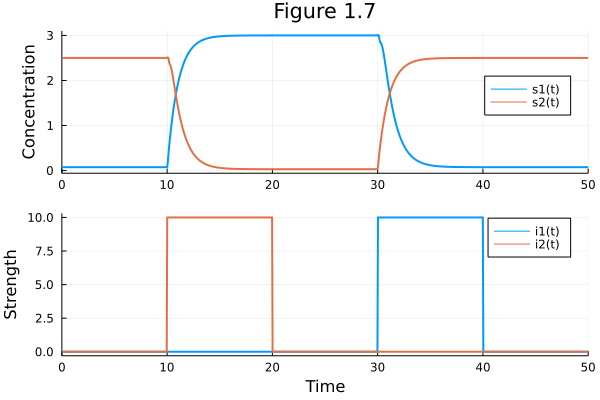

In [9]:
pl0107a = plot(sol, legend=:right, xlabel = "", ylabel="Concentration", title="Figure 1.7")

# Tracking intermediate variables
pl0107b = plot(sol, vars = [i1, i2], xlabel="Time", ylabel="Strength")

plot(pl0107a, pl0107b, layout=(2, 1))

## Fig 1.09 Hodgkin-Huxley model

In [10]:
using DifferentialEquations
using ModelingToolkit
using Plots
Plots.gr(lw=2, fmt=:png)

Plots.GRBackend()

In [11]:
# Convenience functions
hill(x, k) = x / (x + k)
hill(x, k, n) = hill(x^n, k^n)
exprel(x) = x / expm1(x)

exprel (generic function with 1 method)

In [12]:
# Build the model

@parameters E_N E_K E_LEAK G_N_BAR G_K_BAR G_LEAK C_M
@variables t v(t) m(t) h(t) n(t) mα(t) mβ(t) hα(t) hβ(t) nα(t) nβ(t) iNa(t) iK(t) iLeak(t) iStim(t)

D = Differential(t)

(::Differential) (generic function with 2 methods)

In [13]:
# Time-dependent force
get_istim(t) = ifelse(20<=t<=21, -6.8, ifelse(60<=t<=61, -7.0, 0.0))

@register get_istim(t)

In [14]:
@named hhSys = ODESystem(
   [mα  ~ exprel(-0.10 * (v + 35)),
    mβ  ~ 4.0 * exp(-(v + 60) / 18.0),
    hα  ~ 0.07 * exp(- ( v + 60) / 20),
    hβ  ~ 1 / (exp(-(v+30)/10) + 1),
    nα  ~ 0.1 * exprel(-0.1 * (v+50)),
    nβ  ~ 0.125 * exp( -(v+60) / 80),
    iNa ~ G_N_BAR * (v - E_N) * (m^3) * h,
    iK  ~ G_K_BAR * (v - E_K) * (n^4),
    iLeak ~ G_LEAK * (v - E_LEAK),
    iStim ~ get_istim(t),
    D(v) ~ -(iNa + iK + iLeak + iStim) / C_M,
    D(m) ~ -(mα + mβ) * m + mα,
    D(h) ~ -(hα + hβ) * h + hα,
    D(n) ~ -(nα + nβ) * n + nα]
)

Model hhSys with 14 equations
States (14):
  v(t)
  m(t)
  h(t)
  n(t)
  mα(t)
  mβ(t)
⋮
Parameters (7):
  E_N
  G_N_BAR
  G_K_BAR
  E_K
  E_LEAK
  G_LEAK
⋮
Incidence matrix:sparse([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  2, 6, 3, 7, 3, 8, 4, 9, 4, 10], [1, 2, 3, 4, 5, 5, 5, 5, 5, 5  …  14, 14, 15, 15, 16, 16, 17, 17, 18, 18], Num[×, ×, ×, ×, ×, ×, ×, ×, ×, ×  …  ×, ×, ×, ×, ×, ×, ×, ×, ×, ×], 14, 18)

In [15]:
hhSys = structural_simplify(hhSys)

Model hhSys with 4 equations
States (4):
  v(t)
  m(t)
  h(t)
  n(t)
Parameters (7):
  E_N
  G_N_BAR
  G_K_BAR
  E_K
  E_LEAK
  G_LEAK
⋮
Incidence matrix:sparse([1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 1, 3, 1, 4], [1, 2, 3, 4, 5, 5, 5, 5, 6, 6, 7, 7, 8, 8], Num[×, ×, ×, ×, ×, ×, ×, ×, ×, ×, ×, ×, ×, ×], 4, 8)

In [16]:
params = [  E_N => 55.0,       # Reversal potential of Na (mV)
            E_K => -72.0,      # Reversal potential of K (mV)
            E_LEAK => -49.0,   # Reversal potential of leaky channels (mV)
            G_N_BAR => 120.0,  # Max. Na channel conductance (mS/cm^2)
            G_K_BAR => 36.0,   # Max. K channel conductance (mS/cm^2)
            G_LEAK => 0.30,    # Max. leak channel conductance (mS/cm^2)
            C_M => 1.0]        # membrane capacitance (uF/cm^2)

u0 = [v => -59.8977, m => 0.0536, h => 0.5925, n => 0.3192]
tend = 100.0

100.0

In [17]:
prob = ODEProblem(hhSys, u0, tend, params, jac=true)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: 4-element Vector{Float64}:
 -59.8977
   0.0536
   0.5925
   0.3192

In [18]:
sol = solve(prob, tstops=[20, 60])

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 201-element Vector{Float64}:
   0.0
   0.28649552814013246
   0.6282062631287335
   1.1292780379877847
   1.7885395013858725
   2.7280331405684923
   3.822572061046821
   4.838119051345046
   5.700042622813962
   6.449974924666456
   7.1513264797599865
   7.85049749285601
   8.569189520426825
   ⋮
  80.1960077397332
  81.06031259220867
  82.03898199551966
  83.2071113329784
  84.82646369067459
  86.47972205287024
  88.07675528425885
  90.06829146278412
  92.79622916403545
  95.15639295391775
  97.949720618266
 100.0
u: 201-element Vector{Vector{Float64}}:
 [-59.8977, 0.0536, 0.5925, 0.3192]
 [-59.896772589630615, 0.05358478178533264, 0.592500685682472, 0.3192027439091019]
 [-59.89607841758203, 0.05358354985024715, 0.5925003853539722, 0.31920656870899594]
 [-59.89538070383098, 0.0535873207051992, 0.5924985631920751, 0.3192127047920036]
 [-59.894827103

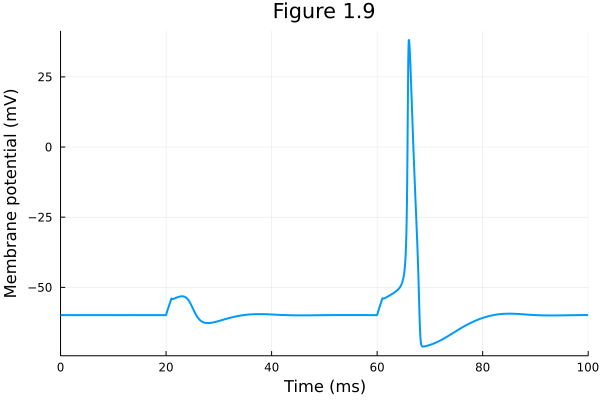

In [19]:
plot(sol, vars=(t, v),
     ylabel="Membrane potential (mV)", xlabel="Time (ms)", 
     legend=false, title="Figure 1.9")

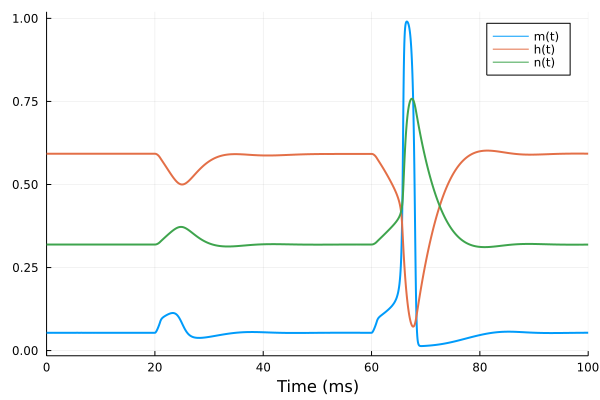

In [20]:
plot(sol, vars = [m, h, n], xlabel="Time (ms)")

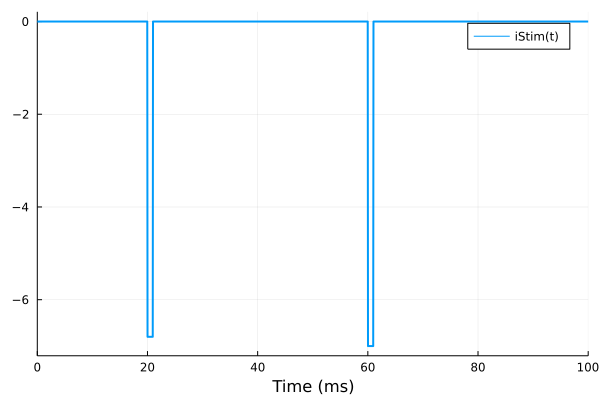

In [21]:
plot(sol, vars = [iStim], xlabel="Time (ms)")